# Reject Inference Compiled Notebook #

### Packages ###

In [110]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, confusion_matrix, roc_auc_score

from imblearn.ensemble import BalancedRandomForestClassifier

from pgmpy.estimators import ExhaustiveSearch, BicScore, BayesianEstimator
from pgmpy.models import BayesianNetwork

import RIfunctions as ri

### Variables ###

In [2]:
RANDOM_STATE = 123
CROSS_VALIDATION = 10
results_df = pd.DataFrame()

In [3]:
# Read CSV files into pandas dataframe
application_df = pd.read_csv('input_file_1.csv', sep = ',', index_col=0)
accept_df = pd.read_csv('input_file_2.csv', sep = ',', index_col=0)

C:\Users\joshy\AppData\Roaming\Python\Python38\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
# Need to split the dataset early for a consistent test dataset
# Removing instances from the application dataset so there is no knowledge

'''Exclude the period from the beginning of 2016 onward as it is noticed in time-series plots that this period has
 a significant portion of the expected defaults not reported yet. This would hence be biased.'''

accept_df['issue_d'] = pd.to_datetime(accept_df['issue_d'])
application_df['issue_d'] = pd.to_datetime(application_df['issue_d'])

application_df = application_df.loc[application_df['issue_d'] < '2016-1-1']
accept_df = accept_df.loc[accept_df['issue_d'] < '2016-1-1']

accept_train_df = accept_df.loc[accept_df['issue_d'] < accept_df['issue_d'].quantile(0.8)]
accept_test_df = accept_df.loc[accept_df['issue_d'] >= accept_df['issue_d'].quantile(0.8)]

print(application_df.shape)

application_df = application_df.loc[application_df['issue_d'] <= max(accept_train_df["issue_d"])]

application_df = application_df.drop('issue_d', axis=1)
accept_test_df = accept_test_df.drop('issue_d', axis=1)
accept_train_df = accept_train_df.drop('issue_d', axis=1)

print(application_df.shape)

(6351001, 6)
(4149346, 5)


## Application Dataset ##

### Pre-processing ###

In [5]:
# Remove instances with a small number of purpose values and align all values

application_df = ri.purposeCleaning(application_df)

<AxesSubplot:>

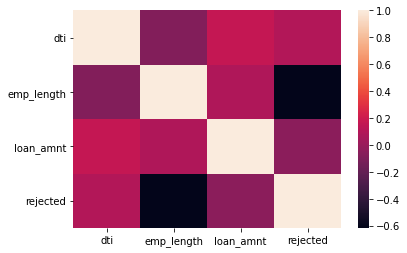

In [6]:
corr = application_df.corr()

sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [7]:
# Get dummies for the purpose variable as it is an object which cannot be interperted   

application_df = pd.get_dummies(application_df, columns=['purpose'], drop_first=False)

In [8]:
# Train the model on the full dataset. We are trying to build a pre-existing, trained model, not a new model.

y_train = application_df['rejected']
X_train = application_df.drop(['rejected'], axis=1)

In [9]:
total, pos, rate = ri.splitCount(application_df['rejected'])

print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, rate))

Training Set:
    Total: 3931748
    Positive: 3432231 (87.30% of total)



### Logistic Regression Model for Application Dataset ###

In [10]:
# # # Optimisation

# pipeline_sgdlogreg = Pipeline([
#     # Alternative is KNNImputer
#     ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
#     ('scaler', StandardScaler(copy=False)),
#     ('model',LogisticRegression(
#         class_weight='balanced',
#         random_state=RANDOM_STATE,
#         n_jobs=-2,
#         warm_start=True
#         )
#     )
# ])

# param_grid_sgdlogreg = {
#     'model__solver': ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear']
# }

# grid_sgdlogreg = GridSearchCV(
#     estimator=pipeline_sgdlogreg,
#     param_grid=param_grid_sgdlogreg,
#     scoring='roc_auc',
#     pre_dispatch=3,
#     n_jobs=-2,
#     cv=CROSS_VALIDATION,
#     verbose=1,
#     return_train_score=False
# )

# grid_sgdlogreg.fit(X_train, y_train)

# print(grid_sgdlogreg.best_estimator_,grid_sgdlogreg.best_params_, grid_sgdlogreg.best_score_)

In [11]:
# Hyperparemeters already optimised

pipeline_logreg = Pipeline([
    ('imputer', SimpleImputer(copy=False)),
    ('scaler', StandardScaler(copy=False)),
    ('model', LogisticRegression(
        class_weight='balanced',
        max_iter=1000, 
        tol = 1e-3,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        warm_start=True,
        solver = 'lbfgs'
        )
    )
])

In [12]:
pipeline_logreg.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                ('scaler', StandardScaler(copy=False)),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, random_state=123, tol=0.001,
                                    warm_start=True))])

In [13]:
cv_scores_lr = cross_val_score(estimator= pipeline_logreg, X=X_train, y=y_train, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("The cross-validation AUC for optimised LR model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores_lr), std(cv_scores_lr)))

The cross-validation AUC for optimised LR model after a 10 fold cross validation: 0.913 (0.016)


In [14]:
# Scores of each application and model performance

y_score = pipeline_logreg.predict_proba(X_train)[:,1]

y_score_flag = [int(round(i)) for i in y_score]

print(roc_auc_score(y_train, y_score), recall_score(y_train, y_score_flag, pos_label=1), recall_score(y_train, y_score_flag, pos_label=0))

0.9149395779299506 0.9099728427369836 0.774380051129391


Confusion matrix, without normalization
[[ 386816  112701]
 [ 308994 3123237]]


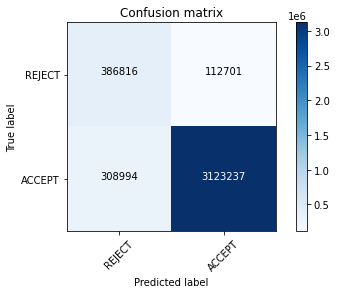

In [15]:
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_train, y_score_flag)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ri.plot_confusion_matrix(cnf_matrix, classes=["REJECT", "ACCEPT"])

plt.show()

In [16]:
results_df = ri.AppendResults(df=results_df, title="LR Application Dataset",
AUC_scores=cv_scores_lr, y_test=y_train, y_score=y_score)


### Save LR Results ###

In [17]:
# Add score column to the dataframe

application_df['score'] = np.hstack(y_score)

In [18]:
# # Undummy the purpose column

def undummy(d):
    return d.dot(d.columns)

application_df = application_df.assign(purpose=application_df.filter(regex='^purpose').pipe(undummy))
application_df['purpose'] = application_df['purpose'].str.replace("purpose_","")
application_df = application_df[application_df.columns.drop(list(application_df.filter(regex="purpose_")))]

In [19]:
# Save to CSV file

application_df.to_csv('AR Scores.csv', mode='w+')

## Accepted Loans Dataset ##

### Pre-processing ###

In [20]:
# Rows with Educational and Renewable Energy purpose have been dropped in the application dataset

accept_train_df = accept_train_df.drop(accept_train_df[accept_train_df['purpose'] == 'educational'].index)
accept_test_df = accept_test_df.drop(accept_test_df[accept_test_df['purpose'] == 'educational'].index)

accept_train_df = accept_train_df.drop(accept_train_df[accept_train_df['purpose'] == 'renewable_energy'].index)
accept_test_df = accept_test_df.drop(accept_test_df[accept_test_df['purpose'] == 'renewable_energy'].index)

In [21]:
all_cols = list(accept_df.columns)
all_cols.remove('charged_off')
all_cols.remove('issue_d')

to_drop_categorical = ['home_ownership', 'verification_status', 'purpose', 'application_type']

for i in to_drop_categorical:

    all_cols.remove(i)

<AxesSubplot:>

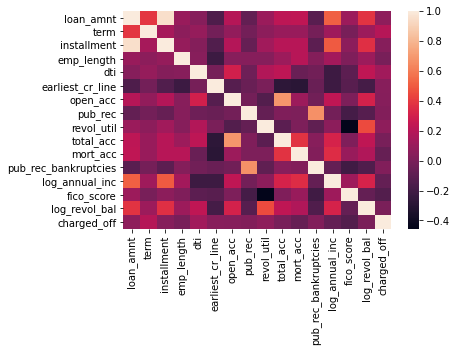

In [22]:
corr = accept_df.corr()

sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [23]:
# Application value did not exist in the training set but did in the test

accept_train_df["at_Joint App"] = 0

accept_train_df_all = pd.get_dummies(accept_train_df,prefix=["ho","vs","purp","at"], columns=['home_ownership', 'verification_status', 'purpose', 'application_type'], drop_first=False)
accept_test_df_all = pd.get_dummies(accept_test_df,prefix=["ho","vs","purp","at"], columns=['home_ownership', 'verification_status', 'purpose', 'application_type'], drop_first=False)


In [24]:
scaler_all = StandardScaler(copy=False)

accept_train_df_all[all_cols] = accept_train_df_all[all_cols].fillna(accept_train_df_all[all_cols].mean())
accept_test_df_all[all_cols] = accept_test_df_all[all_cols].fillna(accept_test_df_all[all_cols].mean())

accept_train_df_all[all_cols] = scaler_all.fit_transform(accept_train_df_all[all_cols], accept_train_df_all['charged_off'])
accept_test_df_all[all_cols] = scaler_all.transform(accept_test_df_all[all_cols])

In [25]:
total, pos, rate = ri.splitCount(accept_train_df_all['charged_off'])
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, rate))

total, pos, rate = ri.splitCount(accept_test_df_all['charged_off'])
print('Testing Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, rate))

Training Set:
    Total: 499517
    Positive: 91418 (18.30% of total)

Testing Set:
    Total: 146571
    Positive: 39267 (26.79% of total)



In [26]:
y_train = accept_train_df_all['charged_off']
y_test = accept_test_df_all['charged_off']

X_train = accept_train_df_all.drop('charged_off', axis=1)
X_test = accept_test_df_all.drop('charged_off', axis=1)


### Random Forest Model ###

In [27]:
# Hyperparameter tuning. Took over 11 hours to run.

# best_hyperparams, best_rf = ri.RandomForestTuning(BalancedRandomForestClassifier(), X_train, y_train, filename = "./random_forest.joblib", cv = CROSS_VALIDATION)
# print("Best hyperparameters: \n", best_hyperparams )

In [28]:
model = joblib.load("./random_forest.joblib")
print(model.get_params())
model.fit(X_train, y_train)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'replacement': False, 'sampling_strategy': 'auto', 'verbose': 0, 'warm_start': False}


BalancedRandomForestClassifier(max_depth=5, n_estimators=50)

In [29]:
cv_scores = cross_val_score(estimator= model, X=X_train, y=y_train, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Training Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores), std(cv_scores)))

(Training Set) The cross-validation AUC for optimised Random Forest model after a 10 fold cross validation: 0.689 (0.014)


In [30]:
yhat = model.predict(X_test)

# Computing Confusion matrix for the above algorithm

# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# ri.plot_confusion_matrix(cnf_matrix, classes=["BAD", "GOOD"])

# plt.show()

C:\Users\joshy\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [31]:
results_df = ri.AppendResults(df=results_df, title="Full RF - Accepts Only",
AUC_scores=cv_scores, y_test=y_test, y_score=yhat)

## Matching Characteristics ##

### Pre-processing ###

In [32]:
numerical_cols = ['loan_amnt', 'emp_length', 'dti']
match_cols = ['loan_amnt', 'emp_length', 'dti','purpose','charged_off']
excl_cols = ['charged_off','weight','score','rejected','accept_score']

accept_train_df_reduced = accept_train_df[match_cols]
accept_test_df_reduced = accept_test_df[match_cols]

In [33]:
accept_train_df_reduced = pd.get_dummies(accept_train_df_reduced, prefix=["purp"], columns=['purpose'], drop_first=False)
accept_test_df_reduced = pd.get_dummies(accept_test_df_reduced, prefix=["purp"], columns=['purpose'], drop_first=False)

In [34]:
scaler_reduced = StandardScaler(copy=False)

accept_train_df_reduced[numerical_cols] = accept_train_df_reduced[numerical_cols].fillna(accept_train_df_reduced[numerical_cols].mean())
accept_test_df_reduced[numerical_cols] = accept_test_df_reduced[numerical_cols].fillna(accept_test_df_reduced[numerical_cols].mean())

accept_train_df_reduced[numerical_cols] = scaler_reduced.fit_transform(accept_train_df_reduced[numerical_cols], accept_train_df_reduced['charged_off'])
accept_test_df_reduced[numerical_cols] = scaler_reduced.transform(accept_test_df_reduced[numerical_cols])

In [35]:
total, pos, rate = ri.splitCount(accept_train_df_reduced['charged_off'])
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, rate))

total, pos, rate = ri.splitCount(accept_test_df_reduced['charged_off'])
print('Testing Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, rate))

Training Set:
    Total: 499517
    Positive: 91418 (18.30% of total)

Testing Set:
    Total: 146571
    Positive: 39267 (26.79% of total)



In [36]:
y_train_reduced = accept_train_df_reduced['charged_off']
y_test_reduced = accept_test_df_reduced['charged_off']

X_train_reduced = accept_train_df_reduced.drop('charged_off', axis=1)
X_test_reduced = accept_test_df_reduced.drop('charged_off', axis=1)

### Random Forest Model ###

In [37]:
# # # Hyperparameter tuning. Took over 11 hours to run.
# # May be interesting to see if the optimised hyperparameters change with reduced characteristics

# best_hyperparams, best_rf = ri.RandomForestTuning(BalancedRandomForestClassifier(), X_train_reduced, y_train_reduced, filename = "./random_forest_reduced.joblib", cv = CROSS_VALIDATION)

# print("Best hyperparameters: \n", best_hyperparams )

In [38]:
model_reduced = joblib.load("./random_forest_reduced.joblib")
print(model_reduced.get_params())
model_reduced.fit(X_train_reduced, y_train_reduced)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'replacement': False, 'sampling_strategy': 'auto', 'verbose': 0, 'warm_start': False}


BalancedRandomForestClassifier(criterion='entropy', max_depth=10,
                               max_features='log2', n_estimators=50)

In [39]:
cv_scores = cross_val_score(estimator= model_reduced, X=X_train_reduced, y=y_train_reduced, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Training Set) The cross-validation AUC for Reduced Random Forest model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores), std(cv_scores)))

(Training Set) The cross-validation AUC for Reduced Random Forest model after a 10 fold cross validation: 0.606 (0.012)


In [40]:
yhat_reduced = model_reduced.predict(X_test_reduced)

In [41]:
results_df = ri.AppendResults(df=results_df, title="Reduced RF - Accepts Only",
AUC_scores=cv_scores, y_test=y_test_reduced, y_score=yhat_reduced)

## Reject Inference Techniques ##

In [42]:
rejected = application_df.loc[application_df["rejected"] == 1]

### Simple Assignment ###

In [43]:
ri_df = pd.concat([accept_train_df, rejected], axis=0, ignore_index=True)
ri_df.loc[ri_df['rejected'] == 1, 'charged_off'] = 1

In [44]:
train_df_sa = ri_df[match_cols]
train_df_sa = ri.RejectPreprocessing(df=train_df_sa, num_cols=numerical_cols, cat_cols=["purpose"], prefix=["purp"], scaler=scaler_reduced)

In [45]:
total, pos, rate = ri.splitCount(train_df_sa['charged_off'])
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, rate))

total, pos, rate = ri.splitCount(accept_test_df_reduced['charged_off'])
print('Testing Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, rate))

Training Set:
    Total: 3931748
    Positive: 3523649 (89.62% of total)

Testing Set:
    Total: 146571
    Positive: 39267 (26.79% of total)



In [46]:
y_train_sa = train_df_sa['charged_off']
X_train_sa = train_df_sa.drop('charged_off', axis=1)

In [47]:
model_ri = joblib.load("./random_forest_reduced.joblib")
print(model_ri.get_params())

model_ri.fit(X_train_sa, y_train_sa)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'replacement': False, 'sampling_strategy': 'auto', 'verbose': 0, 'warm_start': False}


BalancedRandomForestClassifier(criterion='entropy', max_depth=10,
                               max_features='log2', n_estimators=50)

In [48]:
cv_scores = cross_val_score(estimator= model_ri, X=X_train_sa, y=y_train_sa, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Training Set) The cross-validation AUC for optimised Random Forest model with SA RI after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores), std(cv_scores)))

(Training Set) The cross-validation AUC for optimised Random Forest model with SA RI after a 10 fold cross validation: 0.949 (0.039)


In [49]:
yhat_sa = model_ri.predict(X_test_reduced)

In [50]:
results_df = ri.AppendResults(df=results_df, title="Reduced RF - Simple Assignment",
AUC_scores=cv_scores, y_test=y_test_reduced, y_score=yhat_sa)

### Random Assignment ###

In [51]:
total, pos, reject_rate = ri.splitCount(accept_train_df['charged_off'])

reject_rate = reject_rate / 100
random_assign_rate = reject_rate * 3.5

print(reject_rate)
print(random_assign_rate)

# Higher the fraction, bigger the sample
split_BAD = rejected.sample(frac = random_assign_rate, random_state=RANDOM_STATE)
split_GOOD = rejected.drop(split_BAD.index)

split_BAD['charged_off'] = 1
split_GOOD = split_GOOD.assign(charged_off= 0)

ri_df = pd.concat([accept_train_df, split_BAD, split_GOOD], axis=0, ignore_index=True)

0.1830127903554834
0.6405447662441919


In [52]:
train_df_ra = ri.RejectPreprocessing(df=ri_df[match_cols], num_cols=numerical_cols, cat_cols=["purpose"], prefix=["purp"], scaler=scaler_reduced)

In [53]:
total, pos, rate = ri.splitCount(train_df_ra['charged_off'])
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, rate))

total, pos, rate = ri.splitCount(accept_test_df_reduced['charged_off'])
print('Testing Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, rate))

Training Set:
    Total: 3931748
    Positive: 2289916 (58.24% of total)

Testing Set:
    Total: 146571
    Positive: 39267 (26.79% of total)



In [54]:
y_train_ra = train_df_ra['charged_off']
X_train_ra = train_df_ra.drop('charged_off', axis=1)

In [55]:
model_ri.fit(X_train_ra, y_train_ra)

BalancedRandomForestClassifier(criterion='entropy', max_depth=10,
                               max_features='log2', n_estimators=50)

In [56]:
cv_scores = cross_val_score(estimator= model_ri, X=X_train_ra, y=y_train_ra, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Training Set) The cross-validation AUC for optimised Random Forest model with RA RI after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores), std(cv_scores)))

(Training Set) The cross-validation AUC for optimised Random Forest model with RA RI after a 10 fold cross validation: 0.571 (0.168)


In [57]:
yhat_ra = model_reduced.predict(X_test_reduced)

In [58]:
results_df = ri.AppendResults(df=results_df, title="Reduced RF - Random Assignment",
AUC_scores=cv_scores, y_test=y_test_reduced, y_score=yhat_ra)

### Augmentation ###

In [59]:
aug_df = application_df.sort_values(by="score", ascending = False)
aug_df['accept_score'] = 1 - aug_df['score']
intervals = np.array_split(aug_df, 10)

for band in intervals:
    accepts = band.loc[band["rejected"] == 0, "rejected"].count()
    rejects = band.loc[band["rejected"] == 1, "rejected"].count()
    weight = (rejects + accepts) / accepts
    band.drop(band[band['rejected'] == 1].index, inplace=True)
    band['weight'] = weight

aug_df=pd.concat(intervals)
aug_df.drop_duplicates(inplace=True)
aug_df = accept_train_df.merge(aug_df, on=["dti","emp_length","loan_amnt","purpose"], how = 'inner')

In [60]:
train_df_aug_all = ri.RejectPreprocessing(df=aug_df, num_cols=all_cols, cat_cols=['home_ownership', 'verification_status', 'purpose', 'application_type'], prefix=["ho","vs","purp","at"], scaler=scaler_all)

In [61]:
total, pos, rate= ri.splitCount(train_df_aug_all['charged_off'])
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, rate))

total, pos, rate = ri.splitCount(accept_test_df_all['charged_off'])
print('Testing Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, rate))

Training Set:
    Total: 499517
    Positive: 91418 (18.30% of total)

Testing Set:
    Total: 146571
    Positive: 39267 (26.79% of total)



In [62]:
y_train_aug_all = train_df_aug_all['charged_off']
X_train_aug_all = train_df_aug_all.drop(excl_cols, axis=1)
train_weights_aug_all = train_df_aug_all['weight']

In [63]:
model.fit(X_train_aug_all, y_train_aug_all, sample_weight=train_weights_aug_all)

BalancedRandomForestClassifier(max_depth=5, n_estimators=50)

In [64]:
cv_scores = cross_val_score(estimator= model, X=X_train_aug_all, y=y_train_aug_all, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Training Set) The cross-validation AUC for optimised Full Random Forest model with Augmentation after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores), std(cv_scores)))

(Training Set) The cross-validation AUC for optimised Full Random Forest model with Augmentation after a 10 fold cross validation: 0.688 (0.012)


In [65]:
yhat_aug_all = model.predict(X_test)

C:\Users\joshy\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [66]:
results_df = ri.AppendResults(df=results_df, title="Full RF - Augmentation",
AUC_scores=cv_scores, y_test=y_test, y_score=yhat_aug_all)

### Augmentation Reduced Columns ###

In [67]:
aug_cols = ['loan_amnt', 'emp_length', 'dti','purpose','charged_off',"weight"]

In [68]:
train_df_aug_reduced = ri.RejectPreprocessing(df=aug_df[aug_cols], num_cols=numerical_cols, cat_cols=['purpose'], prefix=["purp"], scaler=scaler_reduced)

In [69]:
total, pos, rate= ri.splitCount(train_df_aug_reduced['charged_off'])
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, rate))

total, pos, rate = ri.splitCount(accept_test_df_reduced['charged_off'])
print('Testing Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, rate))

Training Set:
    Total: 499517
    Positive: 91418 (18.30% of total)

Testing Set:
    Total: 146571
    Positive: 39267 (26.79% of total)



In [70]:
y_train_aug_reduced = train_df_aug_reduced['charged_off']
X_train_aug_reduced = train_df_aug_reduced.drop(['charged_off','weight'], axis=1)
train_weights_aug_reduced = train_df_aug_reduced['weight']

In [71]:
model_ri.fit(X_train_aug_reduced, y_train_aug_reduced, sample_weight=train_weights_aug_reduced)

BalancedRandomForestClassifier(criterion='entropy', max_depth=10,
                               max_features='log2', n_estimators=50)

In [72]:
cv_scores = cross_val_score(estimator= model_ri, X=X_train_aug_reduced, y=y_train_aug_reduced, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Training Set) The cross-validation AUC for optimised Full Random Forest model with Augmentation after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores), std(cv_scores)))

(Training Set) The cross-validation AUC for optimised Full Random Forest model with Augmentation after a 10 fold cross validation: 0.605 (0.014)


In [73]:
yhat_aug_reduced = model_ri.predict(X_test_reduced)

In [74]:
results_df = ri.AppendResults(df=results_df, title="Reduced RF - Augmentation",
AUC_scores=cv_scores, y_test=y_test, y_score=yhat_aug_reduced)

### Parcelling ###

In [75]:
aug_df = application_df.sort_values(by="score", ascending = False)

parcel_df_reject = aug_df.loc[aug_df["rejected"] == 1]
parcel_df_accept = aug_df.loc[aug_df["rejected"] == 0]

parcel_df_accept = parcel_df_accept.drop_duplicates()

accept_scores = accept_train_df.merge(parcel_df_accept, on=["dti","emp_length","loan_amnt","purpose"], how = 'left')

# unsure of the number of intervals
reject_intervals = np.array_split(parcel_df_reject, 10)
accept_intervals = np.array_split(accept_scores, 10)

counter = 0

for reject_band in reject_intervals:

    neg, pos = np.bincount(accept_intervals[counter]['charged_off'])
    reject_rate = pos / (neg + pos)
    assign_rate = reject_rate * 3.5

    # Higher the fraction, bigger the sample
    split_BAD = reject_band.sample(frac = assign_rate, random_state=RANDOM_STATE)
    split_GOOD = reject_band.drop(split_BAD.index)

    split_BAD['charged_off'] = 1
    split_GOOD = split_GOOD.assign(charged_off= 0)
    
    accept_scores = pd.concat([accept_scores, split_BAD, split_GOOD], axis=0, ignore_index=True)
    counter = counter + 1

In [76]:
train_df_PARCEL_reduced = ri.RejectPreprocessing(df=accept_scores[match_cols], num_cols=numerical_cols, cat_cols=['purpose'], prefix=["purp"], scaler=scaler_reduced)

In [77]:
total, pos, rate = ri.splitCount(train_df_PARCEL_reduced['charged_off'])
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, rate))

total, pos, rate = ri.splitCount(accept_test_df_reduced['charged_off'])
print('Testing Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, rate))

Training Set:
    Total: 3931748
    Positive: 2289915 (58.24% of total)

Testing Set:
    Total: 146571
    Positive: 39267 (26.79% of total)



In [78]:
y_train_PARCEL_reduced = train_df_PARCEL_reduced['charged_off']
X_train_PARCEL_reduced = train_df_PARCEL_reduced.drop(['charged_off'], axis=1)

In [79]:
model_ri.fit(X_train_PARCEL_reduced, y_train_PARCEL_reduced)

BalancedRandomForestClassifier(criterion='entropy', max_depth=10,
                               max_features='log2', n_estimators=50)

In [80]:
cv_scores = cross_val_score(estimator= model_ri, X=X_train_PARCEL_reduced, y=y_train_PARCEL_reduced, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Training Set) The cross-validation AUC for optimised Reduced Random Forest model with Parcelling after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores), std(cv_scores)))

(Training Set) The cross-validation AUC for optimised Reduced Random Forest model with Parcelling after a 10 fold cross validation: 0.385 (0.275)


In [81]:
yhat_PARCEL_reduced = model_ri.predict(X_test_reduced)

In [82]:
results_df = ri.AppendResults(df=results_df, title="Reduced RF - Parcelling",
AUC_scores=cv_scores, y_test=y_test, y_score=yhat_PARCEL_reduced)

### Extrapolation ###

In [83]:
rejects_extrapolation = rejected.drop(['rejected','score'], axis=1)

In [84]:
rejects_extrapolation = ri.RejectPreprocessing(df=rejects_extrapolation, num_cols=numerical_cols, cat_cols=['purpose'], prefix=["purp"], scaler=scaler_reduced)

In [85]:
reject_bad_prob = model_reduced.predict_proba(rejects_extrapolation)

C:\Users\joshy\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [86]:
total, pos, rate = ri.splitCount(accept_train_df_reduced['charged_off'])

In [87]:
# No rejects scored below the rate because of the lack of variables
# Suggestion for further work would be to change the rates

print("Rate: ", rate)
rate = 1 - (rate/100)

rejects_extrapolation['bad_prob'] = reject_bad_prob[:,1]
rejects_extrapolation['charged_off'] = np.where(rejects_extrapolation['bad_prob'] >= rate, 1, 0)
rejects_extrapolation.drop('bad_prob', axis=1, inplace=True)

train_df_EXTRAPOLATION_reduced = pd.concat([accept_train_df_reduced, rejects_extrapolation])

Rate:  18.30127903554834


In [88]:
total, pos, rate = ri.splitCount(train_df_EXTRAPOLATION_reduced['charged_off'])
print('Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, rate))

total, pos, rate = ri.splitCount(accept_test_df_reduced['charged_off'])
print('Testing Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, rate))

Training Set:
    Total: 3931748
    Positive: 91506 (2.33% of total)

Testing Set:
    Total: 146571
    Positive: 39267 (26.79% of total)



In [89]:
y_train_EXTRAPOLATION_reduced = train_df_EXTRAPOLATION_reduced['charged_off']
X_train_EXTRAPOLATION_reduced = train_df_EXTRAPOLATION_reduced.drop(['charged_off'], axis=1)

In [90]:
model_ri.fit(X_train_EXTRAPOLATION_reduced, y_train_EXTRAPOLATION_reduced)

BalancedRandomForestClassifier(criterion='entropy', max_depth=10,
                               max_features='log2', n_estimators=50)

In [91]:
cv_scores = cross_val_score(estimator= model_ri, X=X_train_EXTRAPOLATION_reduced, y=y_train_EXTRAPOLATION_reduced, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Training Set) The cross-validation AUC for Reduced Random Forest - Exrapolated RI model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores), std(cv_scores)))

(Training Set) The cross-validation AUC for Reduced Random Forest - Exrapolated RI model after a 10 fold cross validation: 0.916 (0.134)


In [92]:
yhat_EXTRAPOLATION_reduced = model_ri.predict(X_test_reduced)

In [93]:
results_df = ri.AppendResults(df=results_df, title="Reduced RF - Extrapolation",
AUC_scores=cv_scores, y_test=y_test, y_score=yhat_EXTRAPOLATION_reduced)

### Fuzzy Augmentation ###

In [95]:
rejected_bad = application_df.loc[application_df["rejected"] == 1]
rejected_good = application_df.loc[application_df["rejected"] == 1]

In [96]:
rejected_good["score"] = 1 - rejected_good["score"]
rejected_good["charged_off"] = 0

rejected_bad["charged_off"] = 1

fuzzy_aug = pd.concat([rejected_good, rejected_bad])

<ipython-input-96-336b99dc05cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rejected_good["score"] = 1 - rejected_good["score"]
<ipython-input-96-336b99dc05cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rejected_good["charged_off"] = 0
<ipython-input-96-336b99dc05cf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [135]:
accept_train_aug_df_reduced = accept_train_df[match_cols]
accept_train_aug_df_reduced['score'] = 1

<ipython-input-135-6cfeb8af96e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accept_train_aug_df_reduced['score'] = 1


In [98]:
train_aug_df_reduced = pd.concat([accept_train_aug_df_reduced, fuzzy_aug])

In [99]:
train_aug_df_reduced = ri.RejectPreprocessing(df=train_aug_df_reduced, num_cols=numerical_cols, cat_cols=['purpose'], prefix=["purp"], scaler=scaler_reduced)

In [100]:
y_train_faug_reduced = train_aug_df_reduced['charged_off']
X_train_faug_reduced = train_aug_df_reduced.drop(['charged_off',"score", 'rejected'], axis=1)
train_weights_faug = train_aug_df_reduced['score']

In [101]:
model_ri.fit(X_train_faug_reduced, y_train_faug_reduced, sample_weight = train_weights_faug)

BalancedRandomForestClassifier(criterion='entropy', max_depth=10,
                               max_features='log2', n_estimators=50)

In [102]:
cv_scores = cross_val_score(estimator= model_ri, X=X_train_faug_reduced, y=y_train_faug_reduced, scoring='roc_auc', cv=CROSS_VALIDATION, n_jobs=-1)
print("(Training Set) The cross-validation AUC for Reduced Random Forest - Fuzzy Aug RI model after a 10 fold cross validation: %.3f (%.3f)" % (mean(cv_scores), std(cv_scores)))

(Training Set) The cross-validation AUC for Reduced Random Forest - Fuzzy Aug RI model after a 10 fold cross validation: 0.498 (0.056)


In [103]:
yhat_faug_reduced = model_ri.predict(X_test_reduced)

In [104]:
results_df = ri.AppendResults(df=results_df, title="Reduced RF - Fuzzy Augmentation",
AUC_scores=cv_scores, y_test=y_test, y_score=yhat_faug_reduced)

In [106]:
# Save to CSV file
results_df.to_csv('Results.csv', mode='w+')

### Bayesian Network ###

In [136]:
bn_df = accept_train_aug_df_reduced
emp_length_mean = bn_df['emp_length'].mean()
bn_df['emp_length'].fillna(emp_length_mean, inplace=True)

C:\Users\joshy\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [137]:
bn_df['emp_length_cat'], emp_bins = pd.qcut(bn_df['emp_length'], q=3, retbins=True)
bn_df['dti_cat'], dti_bins = pd.qcut(bn_df['dti'], q=4, retbins=True)
bn_df['loan_amnt_cat'], loan_bins = pd.qcut(bn_df['loan_amnt'], q=4, retbins=True)

bn_df['emp_length_cat'] = bn_df['emp_length_cat'].astype(str)
bn_df['dti_cat'] = bn_df['dti_cat'].astype(str)
bn_df['loan_amnt_cat'] = bn_df['loan_amnt_cat'].astype(str)

emp_length_cat_lb = str(emp_bins[-1])
dti_cat_lb = str(dti_bins[-1])
loan_amnt_cat_lb = str(loan_bins[-1])

emp_length_open_cat = str(emp_bins[-2]) + " <"
dti_open_cat = str(dti_bins[-2]) + " <"
loan_amnt_open_cat = str(loan_bins[-2]) + " <"

bn_df.loc[bn_df["emp_length_cat"].str.contains(emp_length_cat_lb), "emp_length_cat"] = emp_length_open_cat
bn_df.loc[bn_df["dti_cat"].str.contains(dti_cat_lb), "dti_cat"] = dti_open_cat
bn_df.loc[bn_df["loan_amnt_cat"].str.contains(loan_amnt_cat_lb), "loan_amnt_cat"] = loan_amnt_open_cat

bn_df = bn_df.drop(['loan_amnt', 'emp_length', 'dti','score'], axis=1)

<ipython-input-137-b8e4cdfb24a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bn_df['emp_length_cat'], emp_bins = pd.qcut(bn_df['emp_length'], q=3, retbins=True)
<ipython-input-137-b8e4cdfb24a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bn_df['dti_cat'], dti_bins = pd.qcut(bn_df['dti'], q=4, retbins=True)
<ipython-input-137-b8e4cdfb24a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [141]:
bn_rejects = rejected
bn_rejects['emp_length'].fillna(emp_length_mean, inplace = True)
bn_rejects = bn_rejects.drop(['rejected', 'score'], axis=1)

# Need to bin the reject continous variables
bn_rejects['emp_length_cat'] = pd.cut(bn_rejects["emp_length"], bins=emp_bins, include_lowest=True).astype(str)
bn_rejects['dti_cat'] = pd.cut(bn_rejects["dti"], bins=dti_bins, include_lowest=True).astype(str)
bn_rejects['loan_amnt_cat'] = pd.cut(bn_rejects["loan_amnt"], bins=loan_bins, include_lowest=True).astype(str)

# Filling values that are in the rejcted dataset outside the threshold of the application dataset bins
bn_rejects['dti_cat'].fillna(dti_open_cat, inplace = True)
bn_rejects['loan_amnt_cat'].fillna(loan_amnt_open_cat, inplace = True)

bn_rejects.loc[bn_rejects["emp_length_cat"].str.contains(emp_length_cat_lb), "emp_length_cat"] = emp_length_open_cat
bn_rejects.loc[bn_rejects["dti_cat"].str.contains(dti_cat_lb), "dti_cat"] = dti_open_cat
bn_rejects.loc[bn_rejects["loan_amnt_cat"].str.contains(loan_amnt_cat_lb), "loan_amnt_cat"] = loan_amnt_open_cat

bn_rejects = bn_rejects.drop(['loan_amnt', 'emp_length', 'dti'], axis=1)

C:\Users\joshy\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [143]:
print(bn_rejects.columns)
print(list(set(bn_rejects['purpose']) - set(bn_df['purpose'])))
print(list(set(bn_df['purpose']) - set(bn_rejects['purpose'])))

Index(['purpose', 'emp_length_cat', 'dti_cat', 'loan_amnt_cat'], dtype='object')
[]
[]


In [ ]:
# Network structure optimisation

scoring_method = BicScore(data=bn_df)
# est = HillClimbSearch(data=df)
est = ExhaustiveSearch(data=bn_df, scoring_method=scoring_method)
estimated_model = est.estimate()

print(estimated_model.edges())

# print("\nAll DAGs by score:")
# for score, dag in reversed(est.all_scores()):
#     print(score, dag.edges())

In [147]:
bn_model = BayesianNetwork(estimated_model)
bn_model.fit(bn_df, estimator=BayesianEstimator, prior_type="BDeu") # Bayesian Dirichlet equivalent uniform prior
for cpd in bn_model.get_cpds():
    print(cpd)


+----------------+-----+--------------------------+
| loan_amnt_cat  | ... | loan_amnt_cat(19750.0 <) |
+----------------+-----+--------------------------+
| charged_off(0) | ... | 0.7883193879414675       |
+----------------+-----+--------------------------+
| charged_off(1) | ... | 0.2116806120585325       |
+----------------+-----+--------------------------+
+--------------------------+-----+--------------------------+
| charged_off              | ... | charged_off(1)           |
+--------------------------+-----+--------------------------+
| loan_amnt_cat            | ... | loan_amnt_cat(19750.0 <) |
+--------------------------+-----+--------------------------+
| dti_cat((-0.001, 11.37]) | ... | 0.16938030065278917      |
+--------------------------+-----+--------------------------+
| dti_cat((11.37, 16.92])  | ... | 0.23078135592416837      |
+--------------------------+-----+--------------------------+
| dti_cat((16.92, 22.91])  | ... | 0.27875685618253443      |
+---------------

In [148]:
joblib.dump(bn_model, "./BN model.joblib")

['./BN model.joblib']

In [172]:
bn_yhat['charged_off_1'].value_counts()

0.117379    1665
0.275939    1319
0.188791    1311
0.135005     573
0.236201     541
0.156676     505
0.269411     505
0.160495     475
0.129218     380
0.222353     252
0.184408     251
0.149423     205
0.154385     191
0.183012     185
0.206911     117
0.173586     106
Name: charged_off_1, dtype: int64

In [152]:
max(bn_yhat["charged_off_1"])

0.27593852935724306

In [153]:
bn_df['charged_off'].value_counts()

0    408099
1     91418
Name: charged_off, dtype: int64

In [154]:
bn_rejects.shape

(3432231, 4)

In [ ]:
chunks = np.array_split(bn_rejects, 400)

for i in chunks:
    bn_yhat = bn_model.predict_probability(i)
    i['default_prob'] = bn_yhat['charged_off_1']

In [197]:
chunks[0]

,purpose,emp_length_cat,dti_cat,loan_amnt_cat,default_prob
1273538,debt_consolidation,"(-0.001, 4.0]","(16.92, 22.91]",19750.0 <,0.222353
1275072,debt_consolidation,"(-0.001, 4.0]","(-0.001, 11.37]",19750.0 <,0.160495
1275572,debt_consolidation,9.0 <,22.91 <,19750.0 <,0.275939
1275577,debt_consolidation,9.0 <,22.91 <,19750.0 <,0.275939
1275634,other,"(-0.001, 4.0]","(16.92, 22.91]","(499.999, 8000.0]",0.156676
...,...,...,...,...,...
1358427,car,"(-0.001, 4.0]","(11.37, 16.92]","(499.999, 8000.0]",0.135005
1358429,debt_consolidation,9.0 <,"(16.92, 22.91]","(8000.0, 12000.0]",0.183012
1358431,debt_consolidation,"(-0.001, 4.0]",22.91 <,"(12000.0, 19750.0]",0.269411
1358432,debt_consolidation,"(-0.001, 4.0]","(-0.001, 11.37]","(499.999, 8000.0]",0.117379


In [199]:
bn_yhat_df=pd.concat(chunks)

In [200]:
bn_yhat_df

,purpose,emp_length_cat,dti_cat,loan_amnt_cat,default_prob
1273538,debt_consolidation,"(-0.001, 4.0]","(16.92, 22.91]",19750.0 <,0.222353
1275072,debt_consolidation,"(-0.001, 4.0]","(-0.001, 11.37]",19750.0 <,0.160495
1275572,debt_consolidation,9.0 <,22.91 <,19750.0 <,0.275939
1275577,debt_consolidation,9.0 <,22.91 <,19750.0 <,0.275939
1275634,other,"(-0.001, 4.0]","(16.92, 22.91]","(499.999, 8000.0]",0.156676
...,...,...,...,...,...
13843229,other,"(-0.001, 4.0]",22.91 <,"(499.999, 8000.0]",0.188791
13843230,debt_consolidation,"(-0.001, 4.0]","(-0.001, 11.37]","(499.999, 8000.0]",0.117379
13843231,other,"(-0.001, 4.0]","(-0.001, 11.37]","(499.999, 8000.0]",0.117379
13843232,debt_consolidation,"(-0.001, 4.0]","(16.92, 22.91]","(499.999, 8000.0]",0.156676


In [204]:
bn_yhat_df['default_prob'].value_counts()

0.117379    701570
0.275939    497079
0.188791    489729
0.236201    219201
0.135005    216497
0.160495    199992
0.269411    191731
0.156676    189004
0.129218    163237
0.222353    114923
0.184408    107977
0.149423     93629
0.154385     74226
0.183012     69106
0.206911     52198
0.173586     52132
Name: default_prob, dtype: int64

In [ ]:
# Save to CSV file
bn_yhat_df.to_csv('BN Results.csv', mode='w+')